# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:41<00:00, 2121.52it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# Feature Engineering
* Adding the no. of words in the review as a feature

In [25]:
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

 37%|███████████████████████████▍                                              | 32483/87773 [00:09<00:15, 3494.61it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▌                      | 61203/87773 [00:17<00:07, 3409.13it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 74%|███████████████████████████████████████████████████████                   | 65269/87773 [00:19<00:06, 3442.54it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle

In [26]:
preprocessed_reviews_fe = []
for i in tqdm(range(0,len(preprocessed_reviews_summary))):
    preprocessed_reviews_fe.append(preprocessed_reviews_summary[i]+" "+ preprocessed_reviews[i])

100%|████████████████████████████████████████████████████████████████████████| 87773/87773 [00:00<00:00, 702236.24it/s]


In [27]:
preprocessed_reviews_fe_final = []
for i in tqdm(preprocessed_reviews_fe):
    count = 0;
    for j in i.split(" "):
        count += 1;
    i = i + " " + str(count);
    preprocessed_reviews_fe_final.append(i)

100%|████████████████████████████████████████████████████████████████████████| 87773/87773 [00:00<00:00, 119528.87it/s]


In [32]:
preprocessed_reviews_fe_final[1:10]

['dog lover delites dogs love saw pet store tag attached regarding made china satisfied safe 15',
 'one fruitfly stuck infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid weeks fly stuck going around notepad squishing buggers success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wings frantically within secs unstuck product total waste money 63',
 'not work not waste money worst product gotten long time would rate no star could simply not catch single fly bug sort went hardware store bought old fashioned spiral fly paper effective unuasual influx flys house fall needed something 39',
 'big rip wish would read reviews making purchase basically cardsotck box sticky outside pink ish things look like entrances trap pictures no inside trap flies stuck outside basically fly paper horribly horribly horribly overpr

# [4] Featurization

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews_fe_final, final['Score'], test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


## [4.1] BAG OF WORDS

In [31]:
#BoW 
count_vect = CountVectorizer( min_df = 10) #in scikit-learn

X_train_vect = count_vect.fit_transform(X_train)
X_train_vect = X_train_vect.toarray()
X_cv_vect = count_vect.transform(X_cv)
X_cv_vect = X_cv_vect.toarray()
X_test_vect = count_vect.transform(X_test)
X_test_vect = X_test_vect.toarray()
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews_fe_final)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['10', '100', '101', '102', '103', '104', '105', '106', '107', '108']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 8070)
the number of unique words  8070


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [33]:
tf_idf = TfidfVectorizer(min_df = 10)
X_train_vect_tfidf = tf_idf.fit_transform(X_train)
X_train_vect_tfidf = X_train_vect_tfidf.toarray()
X_test_vect_tfidf = tf_idf.transform(X_test)
X_test_vect_tfidf = X_test_vect_tfidf.toarray()
X_cv_vect_tfidf = tf_idf.transform(X_cv)
X_cv_vect_tfidf = X_cv_vect_tfidf.toarray()

print("some sample features(unique words in the corpus)",tf_idf.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf.transform(preprocessed_reviews_fe_final)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['10', '100', '101', '102', '103', '104', '105', '106', '107', '108']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 8070)
the number of unique words including both unigrams and bigrams  8070


## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec
# compute average word2vec for each review.
i=0
list_of_sent=[]
X_train_list=[]
X_test_list=[]
X_cv_list=[]
for sent in X_train:
    X_train_list.append(sent.split())
    
for sent in X_cv:
    X_cv_list.append(sent.split())
    
for sent in X_test:
    X_test_list.append(sent.split())
    
w2v_model=Word2Vec(X_train_list,min_count=0,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

X_train_vectors = [];
for sent in tqdm(X_train_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_vectors.append(sent_vec)
    

X_cv_vectors = []
for sent in tqdm(X_cv_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)
    
X_test_vectors = []
for sent in tqdm(X_test_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 28966/28966 [01:44<00:00, 277.41it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:

dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))
tfidf_feat = tf_idf.get_feature_names()
tfidf_X_train_vectors = [];
tfidf_X_test_vectors = [];
tfidf_X_cv_vectors = [];

for sent in tqdm(X_train_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_train_vectors.append(sent_vec)

for sent in tqdm(X_test_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_test_vectors.append(sent_vec)
    
for sent in tqdm(X_cv_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_cv_vectors.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 19407/19407 [01:26<00:00, 224.04it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

# Using GridSearchCV

In [36]:
# Please write all the code with proper documentation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9515171540037641


# Using Simple CV

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
print(len(y_cv))
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l1')
    lr.fit(X_train_vect, y_train)
    pred = lr.predict(X_cv_vect)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(X_train_vect)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_vect)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


19407


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  8.04s/it]



The optimal C is (according to accuracy):  1

The optimal C is (according to auc curve (max auc)):  0.1


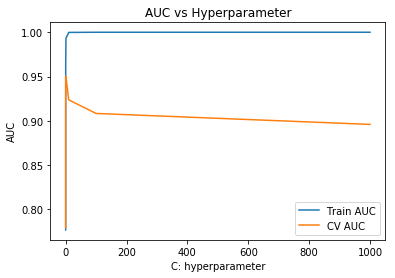

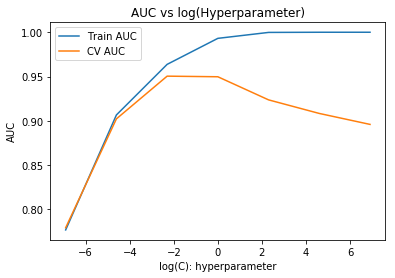

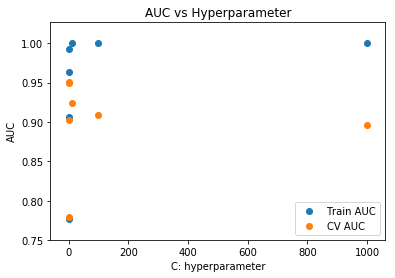

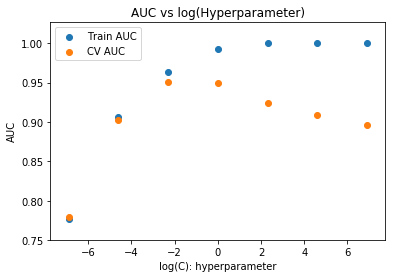

In [38]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for C = 0.100000 is 92.315128%


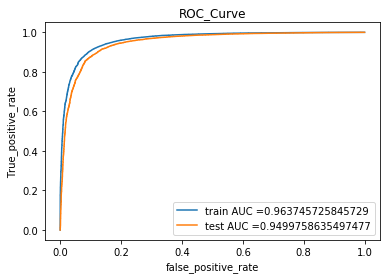

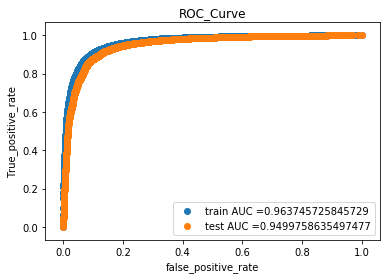

In [44]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l1')
lr.fit(X_train_vect,y_train)
pred = lr.predict(X_test_vect)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_vect)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_vect)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)



Train confusion matrix
[[ 6331     0]
 [    0 33069]]


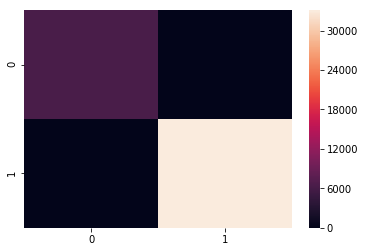

In [39]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, lr.predict(X_train_vect)))
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_vect)))

Test confusion matrix
[[ 3227  1470]
 [ 1590 22679]]


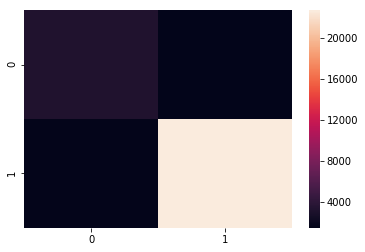

In [40]:
print("Test confusion matrix")
print(confusion_matrix(y_test, lr.predict(X_test_vect)))
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_vect)))

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [42]:
lr = LogisticRegression(C = 0.1,penalty='l1')
lr.fit(X_train_vect, y_train)
print("The accuracy of the model is as follows:")
print(lr.score(X_test_vect, y_test))
w = lr.coef_
w_list = list(w[0])
print("The total no. of weights( corresponding to each feature) are: ")
print(len(w_list))
print("The number of non-zeros weights are the following:")
print(np.count_nonzero(w))

The accuracy of the model is as follows:
0.9231512808119865
The total no. of weights( corresponding to each feature) are: 
8070
The number of non-zeros weights are the following:
657


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

# Using GridSearchCV

In [43]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect, y_test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.955900419691845


# Using Simple CV

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
print(len(y_cv))
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l2')
    lr.fit(X_train_vect, y_train)
    pred = lr.predict(X_cv_vect)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(X_train_vect)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_vect)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


19407


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:12<00:00, 11.36s/it]



The optimal C is (according to accuracy):  0.1

The optimal C is (according to auc curve (max auc)):  0.1


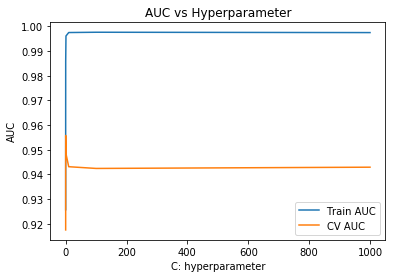

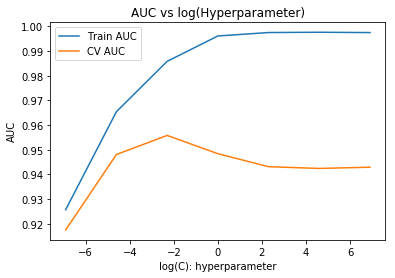

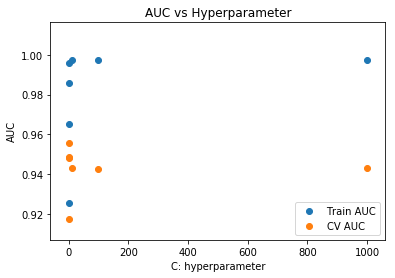

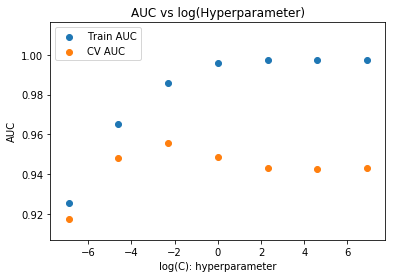

In [46]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for C = 0.100000 is 93.029759%


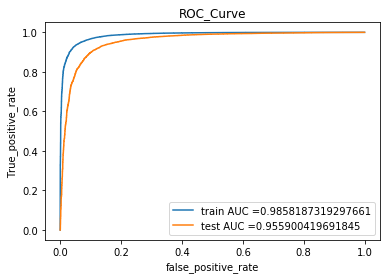

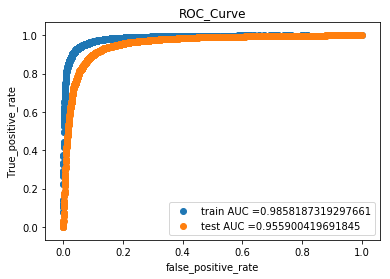

In [47]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l2')
lr.fit(X_train_vect,y_train)
pred = lr.predict(X_test_vect)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_vect)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_vect)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 5028  1303]
 [  377 32692]]


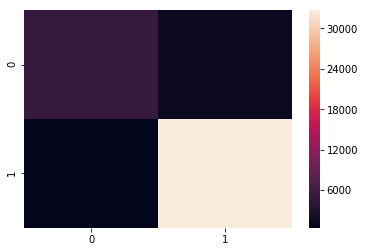

In [48]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_vect)))
print(confusion_matrix(y_train, lr.predict(X_train_vect)))

Test confusion matrix
[[ 3275  1422]
 [  597 23672]]


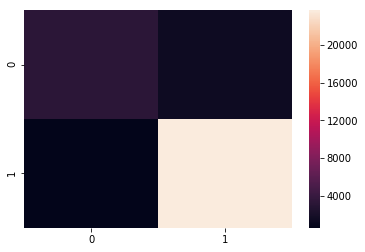

In [49]:
print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_vect)))
print(confusion_matrix(y_test, lr.predict(X_test_vect)))

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [51]:
# Please write all the code with proper documentation
lr = LogisticRegression(C = optimal_c_auc,penalty='l2')
lr.fit(X_train_vect,y_train)
w = lr.coef_
e = 0.0006
X_train_vect_new = X_train_vect + e
lr_new = LogisticRegression(C = optimal_c_auc,penalty='l2')
lr_new.fit(X_train_vect_new, y_train)
w_new = lr_new.coef_
w = w + 0.000006
w_new = w_new + 0.000006

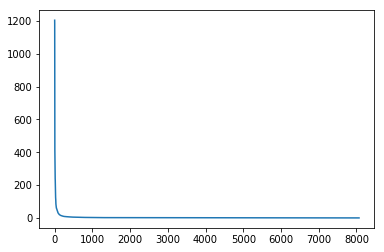

In [54]:
delta_list = []
delta_sorted_list = []
count  = 0
for i in range(w.size):
    delta = abs((w[0][i] - w_new[0][i])/w[0][i])*100
    delta_list.append(delta)
    
vocab = list(count_vect.get_feature_names())
dict_delta = {'Words':vocab,'delta':delta_list}
df_delta = pd.DataFrame(dict_delta)
df_delta_sorted =df_delta.sort_values('delta', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

for i in df_delta_sorted['delta']:
    delta_sorted_list.append(i)
plt.figure(1)
plt.plot(delta_sorted_list)

In [66]:
threshold = np.percentile(delta_sorted_list, 99.8)
threshold

218.73451545642376

In [69]:
print("The following features are colinear:")
collinear_features = df_delta_sorted[df_delta_sorted['delta' ] > threshold]
collinear_features['% Chnage'] = ((collinear_features['delta' ] - threshold)/threshold)*100
collinear_features

The following features are colinear:


,Words,delta,% Chnage
2625,facial,1204.956944,450.876455
3636,increasingly,1184.128338,441.354132
2663,farm,628.948662,187.539742
5361,posts,516.279138,136.030028
3966,lake,441.825604,101.991717
2158,dismay,412.525092,88.596249
1710,counting,386.007584,76.473102
1471,colombia,366.883883,67.730219
7259,thirds,304.121780,39.036941
5665,ranks,273.325747,24.957758


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [70]:
# Please write all the code with proper documentation
vocab = list(count_vect.get_feature_names())
len_of_vocab = len(vocab)
weights = list(lr.coef_[0])
dict_new = {'Words':vocab,'weights':weights}
df_new = pd.DataFrame(dict_new)
df_pos_sorted =df_new.sort_values('weights', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
df_neg_sorted =df_new.sort_values('weights', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print("The important features for predicting the positive class are the following:")
print(df_pos_sorted[0:10])
print("\n")


The important features for predicting the positive class are the following:
          Words   weights
1960  delicious  1.511036
2542  excellent  1.485662
8045      yummy  1.418246
743        best  1.325549
5157    perfect  1.309891
585     awesome  1.305250
3199      great  1.259516
367     amazing  1.226322
7942  wonderful  1.209837
4209      loves  1.167105




#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [71]:
# Please write all the code with proper documentation
print("The important features for predicting the negative class are the following:")
print(df_neg_sorted[0:10])

The important features for predicting the negative class are the following:
               Words   weights
2124   disappointing -1.547931
7205        terrible -1.541295
7973           worst -1.537649
2125  disappointment -1.466658
3484        horrible -1.458794
586            awful -1.369988
2123    disappointed -1.325994
8034            yuck -1.229281
749           beware -1.047595
5995             rip -1.029345


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

# Using GridSearchCV

In [72]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect_tfidf, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect_tfidf, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9620348423719653


# Using Simple CV

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l1')
    lr.fit(X_train_vect_tfidf, y_train)
    pred = lr.predict(X_cv_vect_tfidf)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(X_train_vect_tfidf)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_vect_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:26<00:00,  4.32s/it]



The optimal C is (according to accuracy):  1

The optimal C is (according to auc curve (max auc)):  1


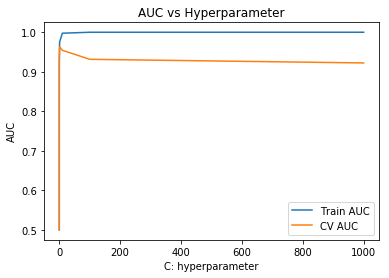

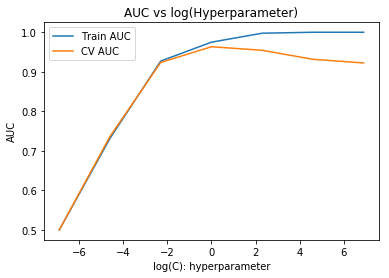

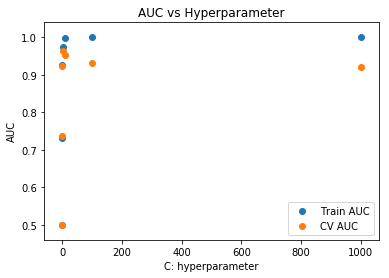

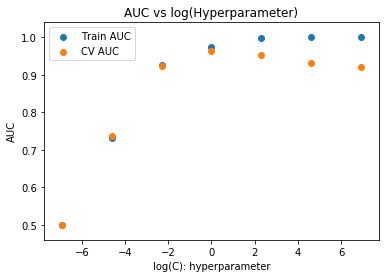

In [74]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for C = 1.000000 is 93.098805%


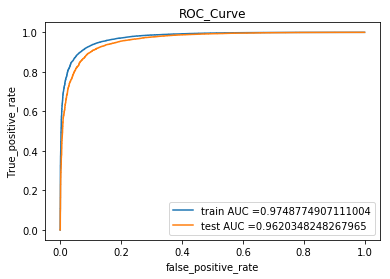

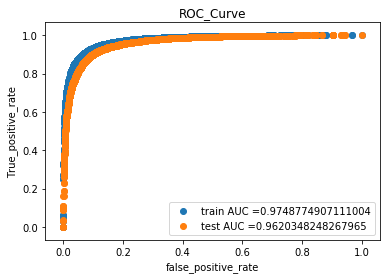

In [75]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l1')
lr.fit(X_train_vect_tfidf,y_train)
pred = lr.predict(X_test_vect_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_vect_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_vect_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)




Train confusion matrix
[[ 4668  1663]
 [  577 32492]]


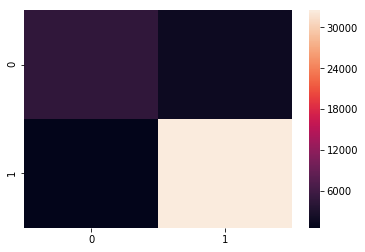

In [76]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, lr.predict(X_train_vect_tfidf)))
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_vect_tfidf)))

Test confusion matrix
[[ 3261  1436]
 [  563 23706]]


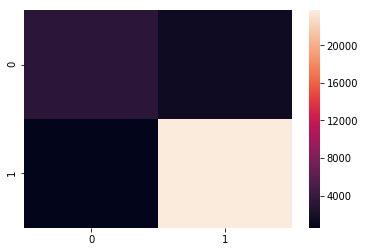

In [77]:
print("Test confusion matrix")
print(confusion_matrix(y_test, lr.predict(X_test_vect_tfidf)))
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_vect_tfidf)))

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

# Using GridSearchCV

In [78]:
tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect_tfidf, y_train)
print(model.best_estimator_)
print(model.score(X_test_vect_tfidf, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9645595746342228


# Using Simple CV

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]

for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l2')
    lr.fit(X_train_vect_tfidf, y_train)
    pred = lr.predict(X_cv_vect_tfidf)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(X_train_vect_tfidf)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_vect_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.81s/it]



The optimal C is (according to accuracy):  10

The optimal C is (according to auc curve (max auc)):  1


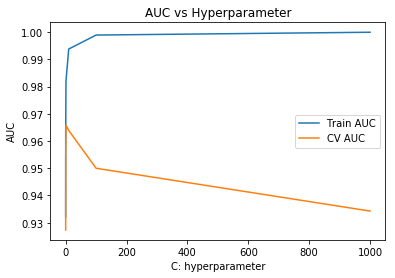

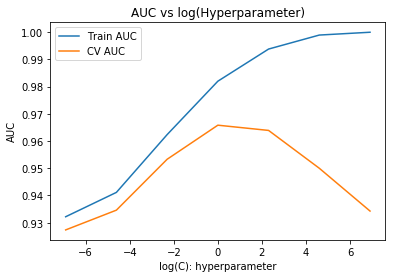

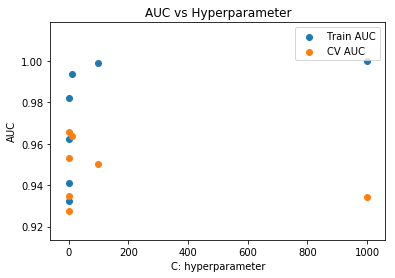

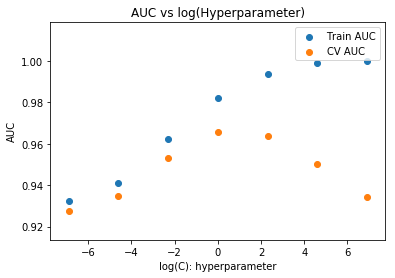

In [80]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


****Test accuracy for C = 1.000000 is 92.788096%


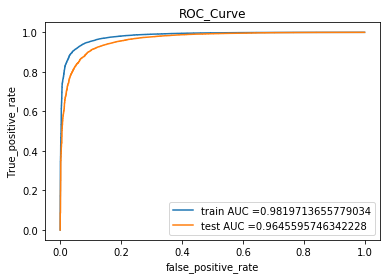

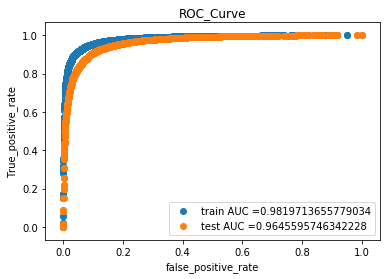

In [81]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l2')
lr.fit(X_train_vect_tfidf,y_train)
pred = lr.predict(X_test_vect_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_vect_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_vect_tfidf)[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 4479  1852]
 [  334 32735]]


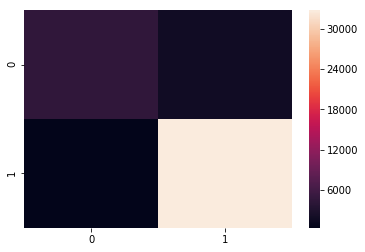

In [82]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, lr.predict(X_train_vect_tfidf)))
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_vect_tfidf)))

Test confusion matrix
[[ 2981  1716]
 [  373 23896]]


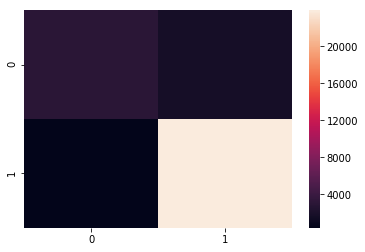

In [83]:
print("Test confusion matrix")
print(confusion_matrix(y_test, lr.predict(X_test_vect_tfidf)))
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_vect_tfidf)))

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [84]:
# Please write all the code with proper documentation
vocab = list(tf_idf.get_feature_names())
len_of_vocab = len(vocab)
weights = list(lr.coef_[0])
dict_new = {'Words':vocab,'weights':weights}
df_new = pd.DataFrame(dict_new)
df_pos_sorted =df_new.sort_values('weights', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
df_neg_sorted =df_new.sort_values('weights', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print("The important features for predicting the positive class are the following:")
print(df_pos_sorted[0:10])



The important features for predicting the positive class are the following:
          Words    weights
3199      great  11.814874
743        best   9.151128
1960  delicious   8.102170
3135       good   7.411501
2542  excellent   6.751298
4204       love   6.258491
5157    perfect   6.253489
4209      loves   6.164610
4738       nice   5.807243
7942  wonderful   5.378079


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [85]:
# Please write all the code with proper documentation
print("The important features for predicting the negative class are the following:")
print(df_neg_sorted[0:10])

The important features for predicting the negative class are the following:
               Words   weights
4772             not -9.059717
2123    disappointed -6.736864
7973           worst -6.037065
3484        horrible -5.937449
7205        terrible -5.861417
2124   disappointing -5.560686
586            awful -5.497599
2125  disappointment -4.815336
4585           money -4.327569
7803           waste -4.170671


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

# Using GridSearchCV

In [86]:
# Please write all the code with proper documentation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vectors, y_train)
print(model.best_estimator_)
print(model.score(X_test_vectors, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9194521998233675


# Using Simple CV

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
print(len(y_cv))
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l1')
    lr.fit(X_train_vectors, y_train)
    pred = lr.predict(X_cv_vectors)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


19407


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.37s/it]



The optimal C is (according to accuracy):  0.1

The optimal C is (according to auc curve (max auc)):  1


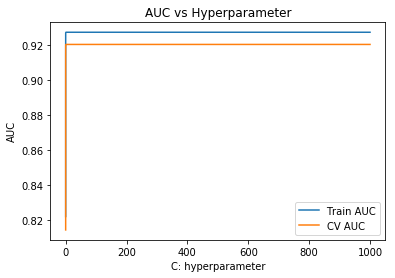

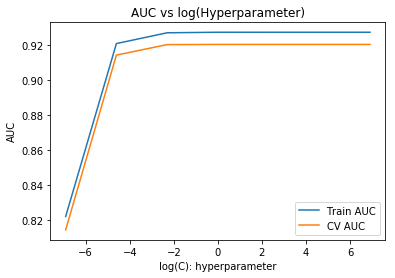

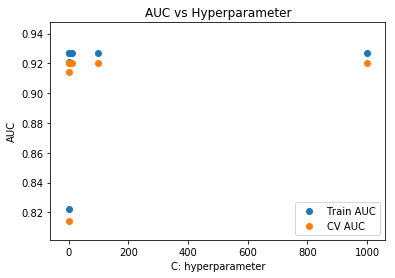

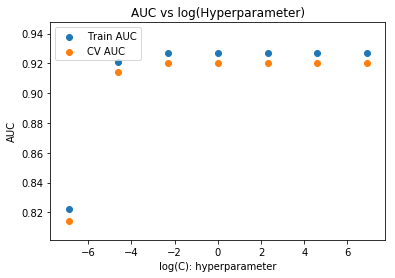

In [88]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


****Test accuracy for C = 1.000000 is 89.653387%


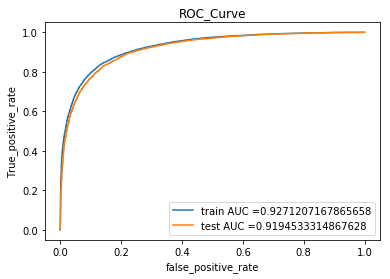

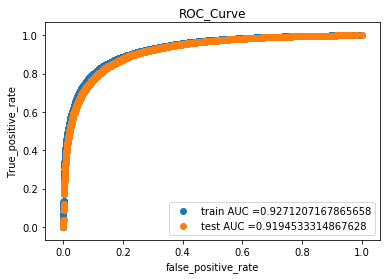

In [89]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l1')
lr.fit(X_train_vectors,y_train)
pred = lr.predict(X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 3591  2740]
 [ 1167 31902]]


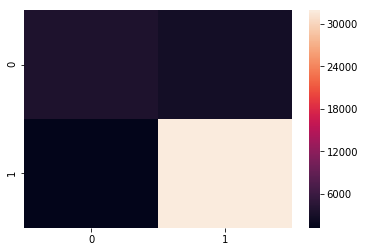

In [90]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, lr.predict(X_train_vectors)))
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_vectors)))

Test confusion matrix
[[ 2565  2132]
 [  865 23404]]


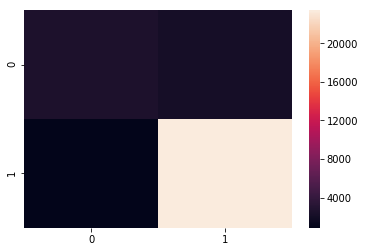

In [91]:
print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_vectors)))
print(confusion_matrix(y_test, lr.predict(X_test_vectors)))

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

# Using GridSearchCV

In [92]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(X_test_vectors, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9194672886686378


# Using Simple CV

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
print(len(y_cv))
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l2')
    lr.fit(X_train_vectors, y_train)
    pred = lr.predict(X_cv_vectors)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  lr.predict_proba(X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


19407


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.13it/s]



The optimal C is (according to accuracy):  1

The optimal C is (according to auc curve (max auc)):  1


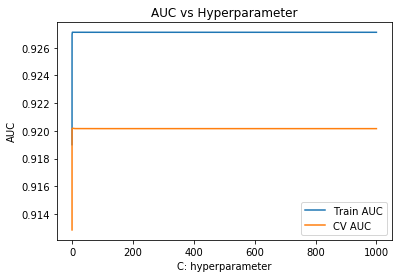

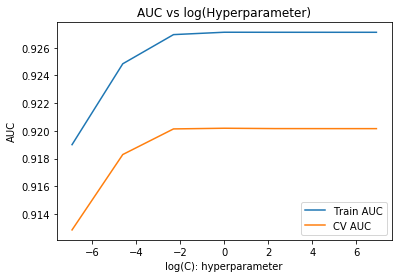

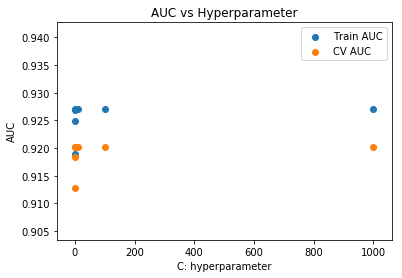

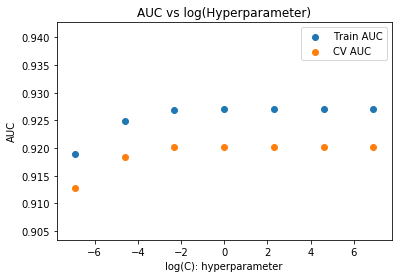

In [113]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


****Test accuracy for C = 1.000000 is 89.656839%


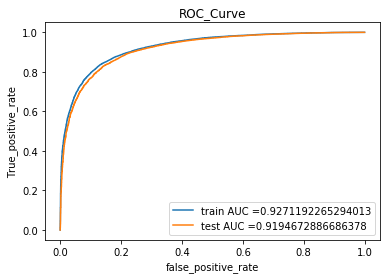

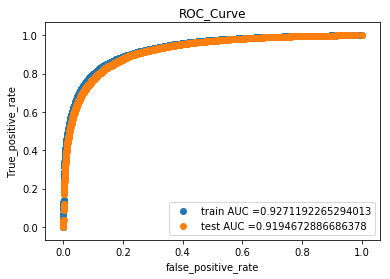

In [114]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l2')
lr.fit(X_train_vectors,y_train)
pred = lr.predict(X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)




Train confusion matrix
[[ 3589  2742]
 [ 1167 31902]]


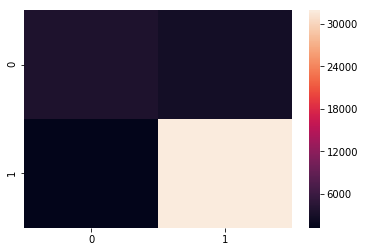

In [96]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_vectors)))
print(confusion_matrix(y_train, lr.predict(X_train_vectors)))

Test confusion matrix
[[ 2564  2133]
 [  863 23406]]


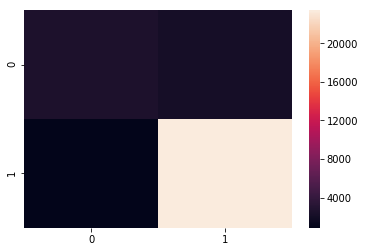

In [97]:
print("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_vectors)))
print(confusion_matrix(y_test, lr.predict(X_test_vectors)))

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

# Using GridSearchCV

In [98]:
# Please write all the code with proper documentation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(tfidf_X_test_vectors, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.894687053533021


# Using Simple CV

In [100]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
print(len(y_cv))
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l1')
    lr.fit(tfidf_X_train_vectors, y_train)
    pred = lr.predict(tfidf_X_cv_vectors)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(tfidf_X_train_vectors)[:,1]
    y_cv_pred =  lr.predict_proba(tfidf_X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


19407


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.91s/it]



The optimal C is (according to accuracy):  10

The optimal C is (according to auc curve (max auc)):  1


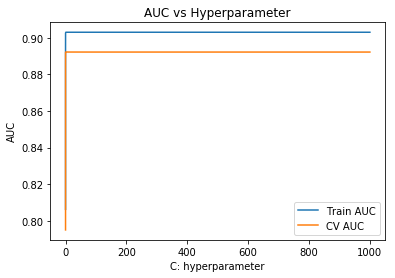

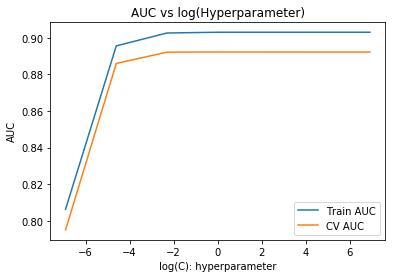

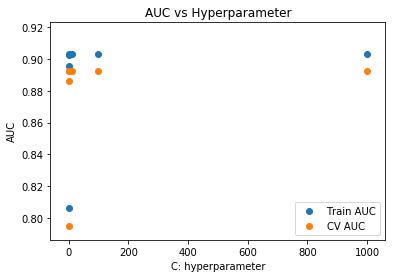

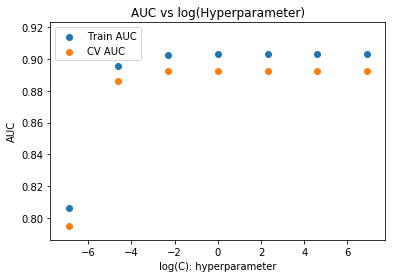

In [101]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


****Test accuracy for C = 1.000000 is 88.182697%


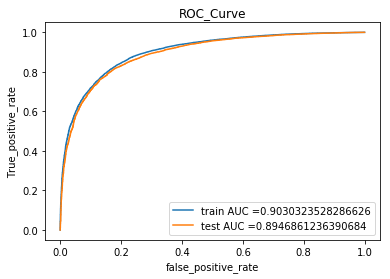

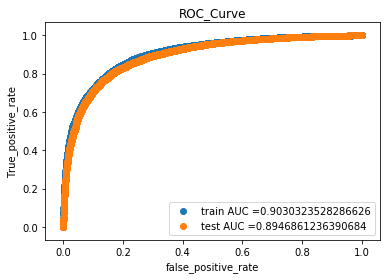

In [102]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l1')
lr.fit(tfidf_X_train_vectors,y_train)
pred = lr.predict(tfidf_X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(tfidf_X_test_vectors)[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 2976  3355]
 [ 1145 31924]]


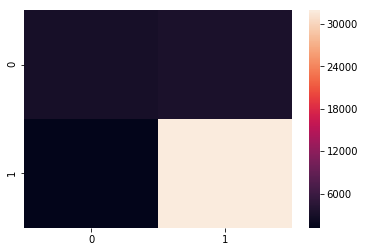

In [103]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, lr.predict(tfidf_X_train_vectors)))
sns.heatmap(confusion_matrix(y_train, lr.predict(tfidf_X_train_vectors)))

Test confusion matrix
[[ 2123  2574]
 [  849 23420]]


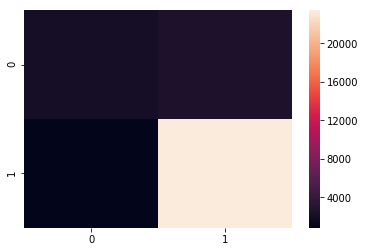

In [104]:
print("Test confusion matrix")
print(confusion_matrix(y_test, lr.predict(tfidf_X_test_vectors)))
sns.heatmap(confusion_matrix(y_test, lr.predict(tfidf_X_test_vectors)))

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

# Using GridSearchCV

In [105]:

# Please write all the code with proper documentation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]}]
c_list = [10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(tfidf_X_test_vectors, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8946641658601664


# Using Simple CV

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

score = []
ind = []
train_auc = []
cv_auc = []
print(len(y_cv))
for i in tqdm(c_list):
    lr = LogisticRegression(C = i,penalty='l2')
    lr.fit(tfidf_X_train_vectors, y_train)
    pred = lr.predict(tfidf_X_cv_vectors)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    score.append(acc)
    ind.append(i)
    y_train_pred =  lr.predict_proba(tfidf_X_train_vectors)[:,1]
    y_cv_pred =  lr.predict_proba(tfidf_X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))



19407


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.06s/it]



The optimal C is (according to accuracy):  1

The optimal C is (according to auc curve (max auc)):  1


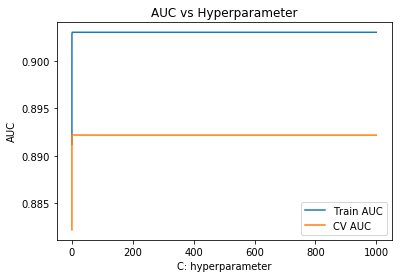

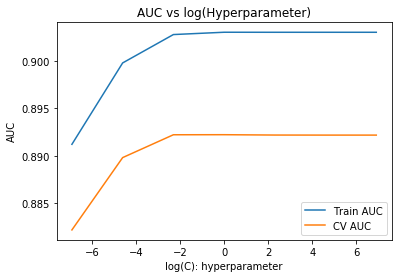

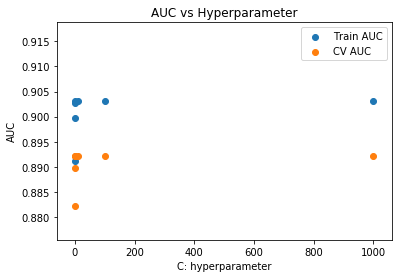

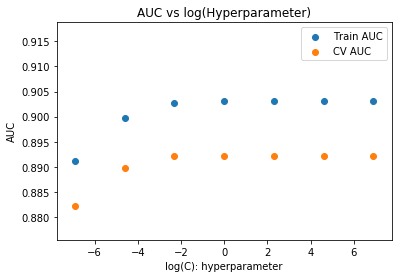

In [107]:
optimal_c_accuracy = ind[score.index(max(score))]
print('\nThe optimal C is (according to accuracy): ' , optimal_c_accuracy)
optimal_c_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal C is (according to auc curve (max auc)): ' , optimal_c_auc)

plt.plot(c_list, train_auc, label='Train AUC')
plt.plot(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(c_list), train_auc, label='Train AUC')
plt.plot(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(c_list, train_auc, label='Train AUC')
plt.scatter(c_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(c_list), train_auc, label='Train AUC')
plt.scatter(np.log(c_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


****Test accuracy for C = 1.000000 is 88.193054%


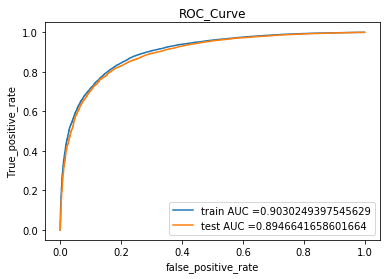

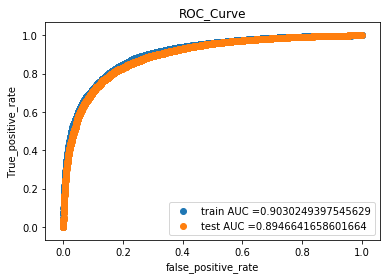

In [108]:
lr = LogisticRegression(C = optimal_c_auc,penalty='l2')
lr.fit(tfidf_X_train_vectors,y_train)
pred = lr.predict(tfidf_X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C = %f is %f%%' % (optimal_c_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(tfidf_X_test_vectors)[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 2982  3349]
 [ 1144 31925]]


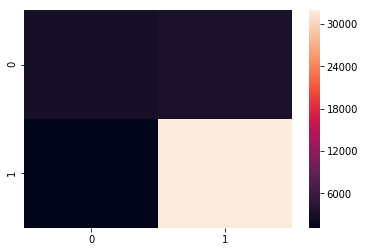

In [109]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, lr.predict(tfidf_X_train_vectors)))
sns.heatmap(confusion_matrix(y_train, lr.predict(tfidf_X_train_vectors)))

Test confusion matrix
[[ 2130  2567]
 [  853 23416]]


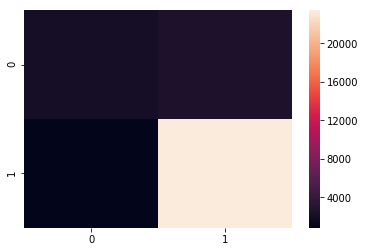

In [110]:
print("Test confusion matrix")
print(confusion_matrix(y_test, lr.predict(tfidf_X_test_vectors)))
sns.heatmap(confusion_matrix(y_test, lr.predict(tfidf_X_test_vectors)))

# [6] Conclusions

In [115]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Regulariser", "Hyperparameter (C)", "AUC"]
x.add_row(["BOW", "L1", 0.1, 0.9499])
x.add_row(["BOW", "L2", 0.1, 0.9559])
x.add_row(["TFIDF", "L1", 1, 0.96203])
x.add_row(["TFIDF", "L2", 1, 0.9645])
x.add_row(["W2V", "L1", 1, 0.9194])
x.add_row(["W2V", "L2", 1, 0.9194])
x.add_row(["TFIDFW2V", "L1", 1, 0.8946])
x.add_row(["TFIDFW2V", "L2", 1, 0.8946])
print(x)


+------------+-------------+--------------------+---------+
| Vectorizer | Regulariser | Hyperparameter (C) |   AUC   |
+------------+-------------+--------------------+---------+
|    BOW     |      L1     |        0.1         |  0.9499 |
|    BOW     |      L2     |        0.1         |  0.9559 |
|   TFIDF    |      L1     |         1          | 0.96203 |
|   TFIDF    |      L2     |         1          |  0.9645 |
|    W2V     |      L1     |         1          |  0.9194 |
|    W2V     |      L2     |         1          |  0.9194 |
|  TFIDFW2V  |      L1     |         1          |  0.8946 |
|  TFIDFW2V  |      L2     |         1          |  0.8946 |
+------------+-------------+--------------------+---------+


* The best model of all is TFIDF with L2 regularizer.
* Out of all the four models the logistic regression performs the worst in TFIDF-W2V
* Feature Engineering by adding the no. of words in a review as a feature as well as considering the texts from summary tend to increase the performance
* Clearly by seeing the confusion matrix, it can be infered that the data set is imbalanced